In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from IPython.display import Audio
from sklearn.metrics import confusion_matrix

In [2]:
def load_data(data_dir):
    paths = []
    labels = []
    for dirname, _, filenames in os.walk('C:\\Users\\Lenovo\\Downloads\\TESS Toronto emotional speech set data'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            label = filename.split('_')[-1].split('.')[0].lower()
            paths.append(path)
            labels.append(label)
    return paths, labels

paths, labels = load_data('C:\\Users\\Lenovo\\Downloads\\TESS Toronto emotional speech set data')

df = pd.DataFrame({'speech': paths, 'label': labels})

def plot_countplot(labels):
    sns.countplot(labels)
    plt.show()

In [3]:
def plot_waveform(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()


def plot_spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

In [4]:
import librosa
emotion ='fear'
path = df['speech'][df['label']==emotion].iloc[0]
data, sampling_rate = librosa.load(path)
#plot_waveform(data, sampling_rate, emotion)
plot_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: single positional indexer is out-of-bounds

In [5]:
def extract_features(paths, labels):
    mfcc_features = []
    for path, label in zip(paths, labels):
        y, sr = librosa.load(path, duration=3, offset=0.5)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        mfcc_features.append(mfcc)
    return np.array(mfcc_features)

In [6]:
def build_model(input_shape, num_classes):
    model = Sequential([
        LSTM(123, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def train_model(X, y, model, epochs=100, batch_size=512, validation_split=0.2):
    history = model.fit(X, y, validation_split=validation_split,
                        epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    return history

In [7]:
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], label='Train accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Train loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

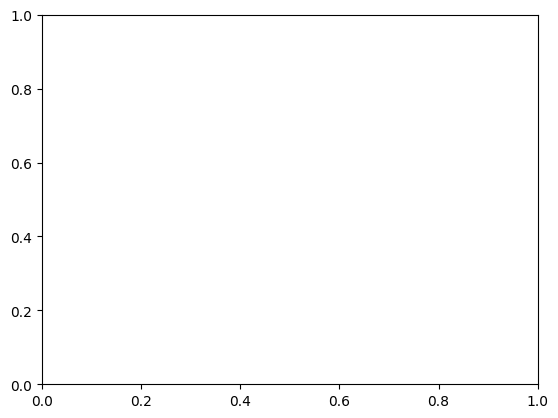

ValueError: zero-size array to reduction operation maximum which has no identity

In [9]:
def main():
    data_dir = 'C:\\Users\\Lenovo\\Downloads\\TESS Toronto emotional speech set data'
    paths, labels = load_data(data_dir)
    plot_countplot(labels)

    X = extract_features(paths, labels)
    X = np.expand_dims(X, -1)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(input_shape=X_train.shape[1:], num_classes=y.shape[1])
    model.summary()

    history = train_model(X_train, y_train, model)

    plot_training_history(history)
    plot_loss_history(history)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    plot_confusion_matrix(y_test_classes, y_pred_classes, label_encoder.classes_)

    model.save('speech_emotion_model.h5')


if __name__ == "__main__":
    main()